## pop2_acp

### Imports & Load datas

In [83]:
import pandas as pd
# google drive folder access
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)
# import pickle

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import decomposition
from sklearn import preprocessing
# classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# classe pour k-means
from sklearn.cluster import KMeans
# classe pour cah
from scipy.cluster.hierarchy import linkage, fcluster

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
# sns.set(style="white")
# sns.set_palette("GnBu_d")
sns.set_style("ticks")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load datas
path_df_base = "./datas/pop2_df_base.csv"
df_base = pd.read_csv(path_df_base, sep=',', error_bad_lines=False, index_col=0)

### Functions

In [84]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(6,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 50 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey", width=0.008)
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='13', ha='right', va='bottom', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure   
            sns.set_style("ticks")
            sns.set_palette("RdBu", n_colors=7)
            fig = plt.figure(figsize=(6,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], marker='.', alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='10', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z):
#     plt.figure(figsize=(4,7))
    plt.figure(figsize=(8,4))
    plt.title('Hierarchical Clustering Dendrogram - Groupe POP2')
    plt.ylabel('distance')
    dendrogram(
        Z,
#         labels = None,
        orientation = "top",
    )
    plt.show()
    
def df_base_disp(columns_names, fig_w, fig_h):

  fig_dims = (fig_w, fig_h)
  nb_plots = len(columns_names)
  fig, axs = plt.subplots(ncols=nb_plots, figsize=fig_dims)
  skewValue = 0
  kurtosis = 0

  for i, name in enumerate(columns_names):
    # print(i, name)
    x_data =  df_base[name]
    # skewvalue
    skewValue = x_data.skew()
    # kurtosis
    kurtosis = x_data.kurtosis()
    disp = "Skew: %0.3f - kurtosis: %0.3f" % (skewValue, kurtosis)
    # print(disp)

    # plot
    # ax = sns.kdeplot(x_data, shade=True, ax=axs[i])
    ax = sns.distplot(x_data, ax=axs[i])
    # add text annotation
    ax.set_title(disp)

### Verification datas

In [87]:
print('df_base.shape :', df_base.shape)
print("Total missing values = ", df_base.isna().sum().sum())
describe_df = df_base[['tage_PS', 'diplome_interv', 'revenu', 'imc', 'restaurationrapide_freq', 'collation_freq', 
         'pain_cereales_bio', 'fruits_legumes_bio', 'produits_laitiers_bio', 'viandes_poissons_bio', 
         'consommation_bio', 'tv_duree', 'ordi_duree', 'travail_duree', 'sedentarite_duree', 
         'activite_total_duree', 'activite_domloissport_duree']].describe()
# describe_df

df_base.shape : (2288, 21)
Total missing values =  0


In [88]:
# print(list(df_base))
# df_base.head()

### Préparation ACP - Centrage et Réduction

In [99]:
# selection des colonnes à prendre en compte dans l'ACP
data_pca = df_base[['revenu', 'imc', 'restaurationrapide_freq', 'collation_freq', 'fruits_legumes_bio', 
                    'tv_duree', 'travail_duree', 'activite_total_duree']]

# Utile pour définitions clusters CAH
# revenu = [df_base.loc[id, "revenu"] for id in df_base.index]
info_sup = [df_base.loc[id, "tage_PS"] for id in df_base.index]

# préparation des données pour l'acp
X = data_pca.values
# names = df_base.index
names = df_base['NOIND']
# features = df_base.columns
features = ['sex_PS', 'tage_PS', 'diplome_interv', 'revenu', 'imc', 'fume', 'restaurationrapide_freq', 
            'collation_freq', 'consommation_bio', 'fruits_legumes_bio', 'tv_duree', 'travail_duree', 
            'activite_total_duree']

# Centrage et Réduction
std_scale = StandardScaler()
X_scaled = std_scale.fit_transform(X)

# vérification moyennes nulles
print('Vérification moyennes nulles')
print(np.mean(X_scaled,axis=0))
print('Vérification écart-type = 1')
print(np.std(X_scaled,axis=0,ddof=0))

Vérification moyennes nulles
[-5.27938222e-17 -6.98741764e-17 -2.79496706e-17 -3.08999136e-16
 -5.43465816e-18  1.68474403e-16  1.69250783e-16 -1.91765795e-16]
Vérification écart-type = 1
[1. 1. 1. 1. 1. 1. 1. 1.]


### X_scaled

In [101]:
pd.DataFrame(X_scaled).head()

,0,1,2,3,4,5,6,7
0,0.969806,-1.523901,0.532334,2.437152,-0.554113,-0.608452,-0.629442,-0.418507
1,0.690064,-0.440060,-0.702990,-1.666210,2.272665,-0.730231,0.288409,0.123710
2,0.690064,0.843164,-0.702990,-0.571771,-0.554113,-1.298524,-0.629442,-1.970875
3,0.690064,0.070645,-0.702990,0.385471,-0.554113,-0.108012,1.290465,1.906884
4,-0.708648,-0.684379,-0.475146,-0.640370,-0.554113,-0.973784,-0.629442,-1.730443


## Etude du nombre de composantes

composantes générées = 8


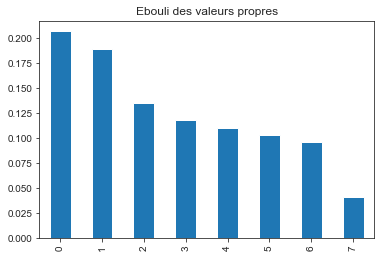


Valeurs ébouli
--------------
0    0.207024
1    0.189216
2    0.134727
3    0.118493
4    0.110215
5    0.103518
6    0.096067
7    0.040740
dtype: float64

Proportions de variance associées aux axes
-------------------------------------------
0 	 0.207024
1 	 0.189216
2 	 0.134727
3 	 0.118493
4 	 0.110215
5 	 0.103518
6 	 0.096067
7 	 0.04074

Infos disponible
----------------
1 composante  => 20.7%
2 composantes => 39.62%
4 composantes => 64.95%
7 composantes => 95.93%

Valeurs propres associées aux axes factoriels
-----------------------------------------------
0 	 1.449801
1 	 1.325093
2 	 0.943502
3 	 0.829816
4 	 0.771843
5 	 0.72494
6 	 0.672761
7 	 0.285306

Vecteurs propres (champ components_ de l'objet ACP)
---------------------------------------------------


,0,1,2,3,4,5,6,7
0,0.298454,-0.216044,0.372420,0.044415,0.042343,-0.209817,0.652954,0.501414
1,-0.224286,0.440322,0.079031,0.058906,-0.396050,0.605980,0.060703,0.467273
2,-0.428730,-0.283828,0.309388,0.778866,0.132453,0.034573,-0.120440,-0.005768
3,-0.089001,-0.080868,-0.487314,-0.008365,0.732268,0.295354,0.075055,0.344835
4,0.696314,0.401639,-0.147330,0.561985,0.063754,0.027587,-0.088443,-0.060428
5,0.172323,0.161822,0.704017,-0.264684,0.459541,0.252274,-0.317663,-0.051877
6,-0.392843,0.695732,0.057894,0.031681,0.261779,-0.455399,0.273488,-0.081019
7,0.004057,0.028294,-0.034109,-0.031090,-0.061811,-0.478062,-0.605227,0.631181


In [143]:
# Calcul des composantes principales
# svd_solver = ‘full’ => algo utilisé pour la décomposition en valeurs singulières
acp = decomposition.PCA(svd_solver='full')
principalComponents = acp.fit_transform(X_scaled)

# nombre de composantes générées
p = acp.n_components_
print("composantes générées =", p)

# Ebouli
ebouli = pd.Series(pca.explained_variance_ratio_)
ebouli.plot(kind='bar', title="Ebouli des valeurs propres")
plt.show()

print('\nValeurs ébouli')
print('--------------')
print(ebouli)

#proportion de variance expliquée
print('\nProportions de variance associées aux axes')
print('-------------------------------------------')
variances_associees = acp.explained_variance_ratio_
# print(variances_associees)
for i, item in enumerate(variances_associees): 
    print(i, '\t', round(item,6))

# recup info des 7 premières valeurs
total_info = round(sum(list(variances_associees[0:7])) * 100, 2)

one_first = 20.70
print("\nInfos disponible")
print("----------------")
print(f"1 composante  => {one_first}%")
print(f"2 composantes => {round(sum(list(variances_associees[0:2])) * 100, 2)}%")
print(f"4 composantes => {round(sum(list(variances_associees[0:4])) * 100, 2)}%")
print(f"7 composantes => {total_info}%")

# Valeurs propres
print('\nValeurs propres associées aux axes factoriels')
print('-----------------------------------------------')
eigval = (n-1)/n*acp.explained_variance_
for i, item in enumerate(eigval): 
    print(i, '\t', round(item,6))
    
print("\nVecteurs propres (champ components_ de l'objet ACP)")
print("---------------------------------------------------")
pd.DataFrame(acp.components_)

### Corrélations variables/axes

In [128]:
# racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]
    
# on affiche pour les 4 premiers axes
# print("Corrélations variables/axes")
pd.DataFrame({'id':data_pca.columns,'F1':corvar[:,0],'F2':corvar[:,1], 'F3':corvar[:,2],'F4':corvar[:,3]})

# Corrélations (variables x facteurs ) 
# - Les facteurs sont en ligne, les variables en colonne   
# - Nous devons en tenir compte pour obtenir les corrélations (variablesxfacteurs,𝑟 )   
# - On prend les racines carrées des valeurs propres 

,id,F1,F2,F3,F4
0,revenu,0.359361,-0.258182,-0.416443,-0.081074
1,imc,-0.260134,0.506866,-0.275694,-0.073666
2,restaurationrapide_freq,0.448423,0.090975,0.300521,-0.443915
3,collation_freq,0.053479,0.067808,0.756544,-0.007620
4,fruits_legumes_bio,0.050984,-0.455904,0.128657,0.667054
5,tv_duree,-0.252636,0.697560,0.033582,0.269051
6,travail_duree,0.786207,0.069877,-0.116988,0.068371
7,activite_total_duree,0.603741,0.537890,-0.005602,0.314124


# Cercle des corrélations

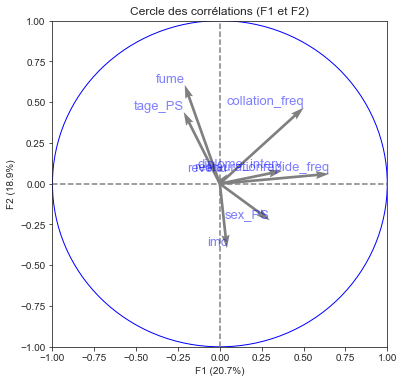

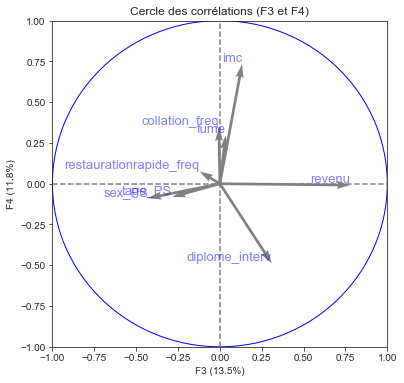

In [149]:
# Cercle des corrélations
n_comp_selected = 4
pcs = acp.components_
display_circles(pcs, n_comp_selected, acp, [(0,1),(2,3),(4,5)], labels = np.array(features))

In [145]:
composantes = pd.DataFrame(principalComponents, columns=['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'])
composantes.head()
# pca.get_precision()

,F1,F2,F3,F4,F5,F6,F7,F8
0,0.408529,-1.085906,2.063448,-1.019905,1.383292,-0.536255,-1.339381,0.308819
1,0.465006,-1.769529,-1.445875,1.843514,-0.437296,0.755934,0.325599,0.178279
2,-1.413643,-1.399317,-1.229106,-1.298395,0.705011,-0.368250,0.690541,-0.139586
3,1.743954,0.966858,-0.476719,0.588978,0.561407,-1.257342,-0.147856,0.525244
4,-1.366849,-1.435116,-0.168972,-0.982014,-0.960143,-0.608456,0.020907,-0.197609


# Projection des individus

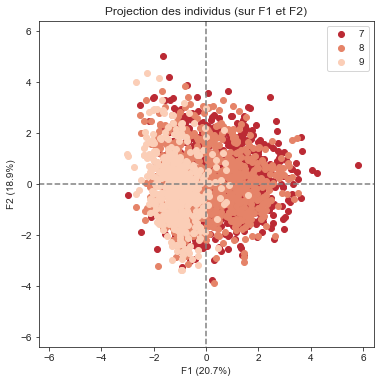

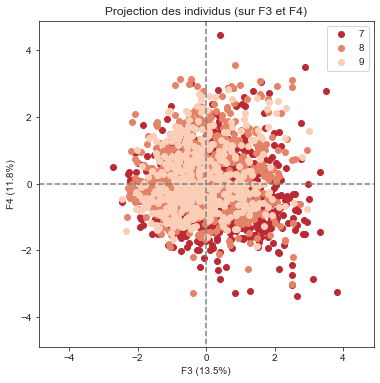

In [146]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp_selected, pca, [(0,1),(2,3),(4,5)], illustrative_var = info_sup, labels = None)
plt.show()

# CAH

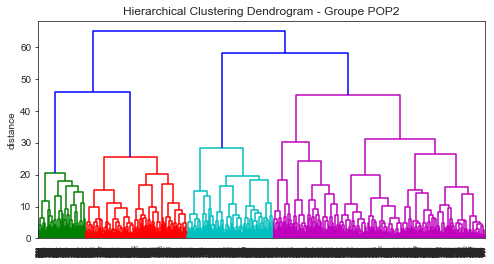

In [153]:
# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')
# Affichage du dendrogramme
plot_dendrogram(Z)

# k-means

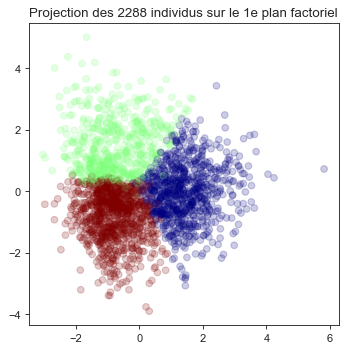

In [152]:
# Nombre de clusters souhaités
n_clust = 3

# import de l'échantillon
data_km = data_pca

# préparation des données pour le clustering
X = data_km.values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X_scaled)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=4).fit(X_scaled)
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))

plt.show(block=False)